In [1]:
import torch  
import torchvision
from torchvision import transforms
import numpy as np  
import random  
from matplotlib import pyplot as plt  
import os  
import shutil
import torch.nn as nn 
import time  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# 启用CUDA加速

In [2]:
def draw(acc1, acc2, loss1, loss2):
    x = range(len(acc1))
    # 创建一个1行2列的图像布局
    plt.figure(figsize=(8, 3))
    # 画图函数
    plt.subplot(1, 2, 1)
    plt.plot(x, acc1, label="train")
    plt.plot(x, acc2, color='r', label="test")
    plt.xlabel("epoch")
    plt.ylabel("acc")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss1, label="train")
    plt.plot(x, loss2, color='r', label="test")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [3]:
def reset(folders):
    for folder in folders:
        for filename in os.listdir(folder):
            filepath = os.path.join(folder, filename)
            if os.path.isfile(filepath) or os.path.islink(filepath):
                os.unlink(filepath)
            elif os.path.isdir(filepath):
                shutil.rmtree(filepath)

# 重置训练集和测试集
folders = ['./cardata/train/car', 
           './cardata/train/bus', 
           './cardata/train/truck',
           './cardata/test/car', 
           './cardata/test/bus', 
           './cardata/test/truck']

# 划分数据集函数
def makedata():
    random.seed(0)
    datapath = os.path.join(os.getcwd(), "cardata")
    traindata = os.path.join(datapath, "train")
    testdata = os.path.join(datapath, "test")
    types = ['car', 'bus', 'truck']
    for t in types:
        tpath = os.path.join(datapath, t)
        images = os.listdir(tpath)
        num = len(images)
        testimg = random.sample(images, k=int(num * 0.25)) # 25%做测试集
        for _, img in enumerate(images):
            if img in testimg:
                # 制作测试集
                imgpath = os.path.join(tpath, img)
                topath = os.path.join(testdata, t)
                shutil.copy(imgpath, topath)
            else:
                # 制作训练集
                imgpath = os.path.join(tpath, img)
                topath = os.path.join(traindata, t)
                shutil.copy(imgpath, topath)

In [4]:
reset(folders)
makedata()
data_transform = {"train": transforms.Compose([transforms.Resize((64 ,64)), # 拉伸到统一大小
                            transforms.RandomHorizontalFlip(),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))]),
                  "test": transforms.Compose([transforms.Resize((64, 64)),
                            transforms.ToTensor(), 
                            transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])}

batch_size = 128
train_dataset = torchvision.datasets.ImageFolder(root = os.path.join(os.getcwd(), "cardata/train"), transform = data_transform["train"])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 8)
test_dataset = torchvision.datasets.ImageFolder(root = os.path.join(os.getcwd(), "cardata/test"), transform = data_transform["test"])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers = 8)

In [5]:
class DilatedConvModule(nn.Module):
    def __init__(self):
        super(DilatedConvModule, self).__init__()
        # 定义一个空洞率为1,2,5的三层空洞卷积
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0, dilation=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, dilation=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=5),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        # 输出层，将通道数变为分类数量
        self.fc = nn.Linear(128, 3)

    def forward(self, X):
        # 图片先经过三层空洞卷积
        out = self.conv(X)
        # 使用平均池化层将图片的大小变为1x1
        out = nn.functional.avg_pool2d(out, 48)
        # 将张量out从shape batch x 128 x 1 x 1 变为 batch x 128
        out = out.squeeze()
        # 输入到全连接层将输出的维度变为10
        out = self.fc(out)
        return out

In [6]:
def train_epoch(net, data_loader, device):
    net.train() 
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0 
    for batch_idx, (data, target) in enumerate(data_loader):
        data = data.to(device).float()
        target = target.to(device).long()
        optimizer.zero_grad()
        output = net(data)
        loss = criterion(output, target)
        # 进行反向传播
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        prediction = torch.argmax(output, 1)
        # 统计预测正确的类别数量
        correct += (prediction == target).sum().item()
        sample_num += len(prediction)
    # 计算平均的loss与准确率
    loss = total_loss / train_batch_num
    acc = correct / sample_num
    return loss, acc

In [7]:
def test_epoch(net, data_loader, device):
    net.eval() 
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0  
    sample_num = 0
    # 指定不进行梯度变化
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(data_loader):
            data = data.to(device).float()
            target = target.to(device).long()
            output = net(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = torch.argmax(output, 1)
            correct += (prediction == target).sum().item()
            sample_num += len(prediction)
    loss = total_loss / test_batch_num
    acc = correct / sample_num
    return loss, acc

Epoch 1: train: loss 0.820752 acc 0.685967; test: loss 1.116784, acc 0.609467
Epoch 2: train: loss 0.549421 acc 0.815505; test: loss 0.765990, acc 0.733728
Epoch 3: train: loss 0.475755 acc 0.836114; test: loss 0.572451, acc 0.804734
Epoch 4: train: loss 0.452113 acc 0.835132; test: loss 0.620668, acc 0.781065
Epoch 5: train: loss 0.423632 acc 0.851816; test: loss 0.497262, acc 0.828402
Epoch 6: train: loss 0.389584 acc 0.856722; test: loss 0.537159, acc 0.784024
Epoch 7: train: loss 0.379855 acc 0.866536; test: loss 0.527345, acc 0.766272
Epoch 8: train: loss 0.352012 acc 0.873405; test: loss 0.616764, acc 0.786982
Epoch 9: train: loss 0.348833 acc 0.872424; test: loss 0.378582, acc 0.866864
Epoch 10: train: loss 0.309982 acc 0.890088; test: loss 0.353423, acc 0.869822
Epoch 11: train: loss 0.287398 acc 0.904809; test: loss 0.601788, acc 0.786982
Epoch 12: train: loss 0.286051 acc 0.898921; test: loss 0.306809, acc 0.887574
Epoch 13: train: loss 0.252493 acc 0.912659; test: loss 0.374

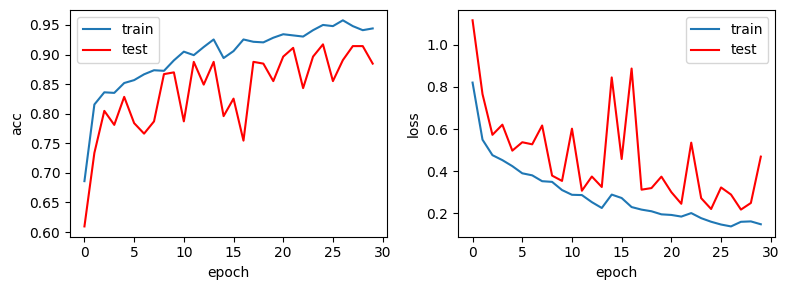

In [8]:
# 模型初始化
lr = 0.01
epochs = 30
net = DilatedConvModule().to(device)  
criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(net.parameters(),lr = lr)   

# 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
timestart = time.time()
# 进行训练
for epoch in range(epochs):
    print('Epoch %d: '%(epoch+1), end="")
    train_loss, train_acc = train_epoch(net, train_loader, device)
    print('train: loss %.6f acc %.6f; '%(train_loss, train_acc), end="")
    test_loss, test_acc = test_epoch(net, test_loader, device)
    print('test: loss %.6f, acc %.6f'%(test_loss, test_acc))
    # 保存各个指标
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
spendtime = (time.time() - timestart)  
print('Spend time: %.3f'%(spendtime))
draw(train_acc_list, test_acc_list, train_loss_list, test_loss_list)

In [9]:
class DilatedConvModule1(nn.Module):
    def __init__(self):
        super(DilatedConvModule1, self).__init__()
        # 定义一个空洞率为1,2,5的三层空洞卷积
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=0, dilation=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, dilation=4),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0, dilation=6),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        # 输出层，将通道数变为分类数量
        self.fc = nn.Linear(128, 3)

    def forward(self, X):
        # 图片先经过三层空洞卷积
        out = self.conv(X)
        # 使用平均池化层将图片的大小变为1x1
        out = nn.functional.avg_pool2d(out, 40)
        # 将张量out从shape batch x 128 x 1 x 1 变为 batch x 128
        out = out.squeeze()
        # 输入到全连接层将输出的维度变为10
        out = self.fc(out)
        return out

Epoch 1: train: loss 0.802331 acc 0.637880; test: loss 1.020515, acc 0.695266
Epoch 2: train: loss 0.462703 acc 0.837095; test: loss 0.620501, acc 0.742604
Epoch 3: train: loss 0.381394 acc 0.848871; test: loss 0.449124, acc 0.819527
Epoch 4: train: loss 0.371145 acc 0.853778; test: loss 0.409869, acc 0.849112
Epoch 5: train: loss 0.314652 acc 0.879293; test: loss 0.341920, acc 0.855030
Epoch 6: train: loss 0.284677 acc 0.892051; test: loss 0.328886, acc 0.881657
Epoch 7: train: loss 0.250653 acc 0.908734; test: loss 0.351103, acc 0.855030
Epoch 8: train: loss 0.258948 acc 0.900883; test: loss 0.345411, acc 0.860947
Epoch 9: train: loss 0.233700 acc 0.910697; test: loss 0.469584, acc 0.784024
Epoch 10: train: loss 0.222766 acc 0.921492; test: loss 0.258977, acc 0.893491
Epoch 11: train: loss 0.214467 acc 0.926398; test: loss 0.270978, acc 0.884615
Epoch 12: train: loss 0.193210 acc 0.936212; test: loss 0.337808, acc 0.866864
Epoch 13: train: loss 0.200290 acc 0.929342; test: loss 0.304

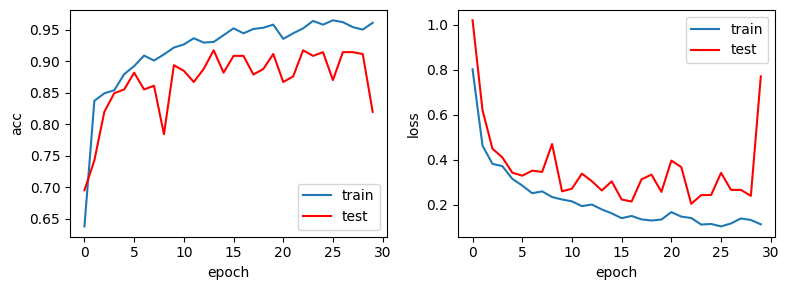

In [10]:
# 改变dilation进行实验HDC(2, 4, 6)
lr = 0.01
net = DilatedConvModule1().to(device)  
optimizer = torch.optim.Adam(net.parameters(),lr = lr)   

# 存储每一个epoch的loss与acc的变化，便于后面可视化
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
timestart = time.time()
# 进行训练
for epoch in range(epochs):
    print('Epoch %d: '%(epoch+1), end="")
    train_loss, train_acc = train_epoch(net, train_loader, device)
    print('train: loss %.6f acc %.6f; '%(train_loss, train_acc), end="")
    test_loss, test_acc = test_epoch(net, test_loader, device)
    print('test: loss %.6f, acc %.6f'%(test_loss, test_acc))
    # 保存各个指标
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
spendtime = (time.time() - timestart)  
print('Spend time: %.3f'%(spendtime))
draw(train_acc_list, test_acc_list, train_loss_list, test_loss_list)